In [274]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from qiskit.circuit.library import ZGate
from qiskit.circuit.library import IntegerComparator
from clc_oracle import apply_clc
from controlled_u import apply_grover_diffusion_operator
from qiskit.primitives import Estimator
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import Aer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
# NEED TO CHANGE SO THAT WE CAN PASS IN GRAPH FROM MAIN NOTEBOOK
def generate_tsp_instance(num_cities):
    G = nx.erdos_renyi_graph(num_cities, 0.9)
    high = (2 * np.pi)/(num_cities * (num_cities - 1) * 0.9)
    for e in G.edges():
        G.add_edge(e[0], e[1], weight=np.round(np.random.uniform(0,high),3))
    # adj_mat = nx.adjacency_matrix(G)
    # total = np.sum(adj_mat)
    # for e in G.edges():
    #     G.add_edge(e[0], e[1], weight=np.round(adj_mat[e[0], e[1]]/total,5))
    return G

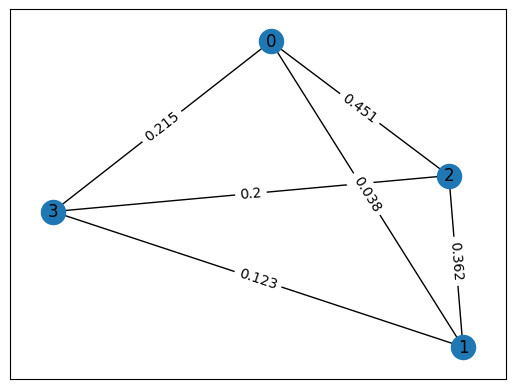

In [317]:
# Define TSP Instance
G = generate_tsp_instance(4)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [318]:
m = 2
t = 3
N = 4
i = 0
p = 0.9
Iopt = np.pi * np.sqrt(2**(m*N)) / 4
constants = {"m":m, "N":N, "t":t, "i":i, "Iopt":Iopt, "p":p}

[0.99927809+0.03799086j 0.90001169+0.43586576j 0.97697639+0.21334743j
 1.        +0.j        ]
[0.99927809+0.03799086j 0.9351904 +0.35414532j 0.99244503+0.12269009j
 1.        +0.j        ]
[0.90001169+0.43586576j 0.9351904 +0.35414532j 0.98006658+0.19866933j
 1.        +0.j        ]
[0.97697639+0.21334743j 0.99244503+0.12269009j 0.98006658+0.19866933j
 1.        +0.j        ]
[0.99927809+0.03799086j 0.90001169+0.43586576j 0.97697639+0.21334743j
 1.        +0.j        ]
[0.99927809+0.03799086j 0.9351904 +0.35414532j 0.99244503+0.12269009j
 1.        +0.j        ]
[0.90001169+0.43586576j 0.9351904 +0.35414532j 0.98006658+0.19866933j
 1.        +0.j        ]
[0.97697639+0.21334743j 0.99244503+0.12269009j 0.98006658+0.19866933j
 1.        +0.j        ]


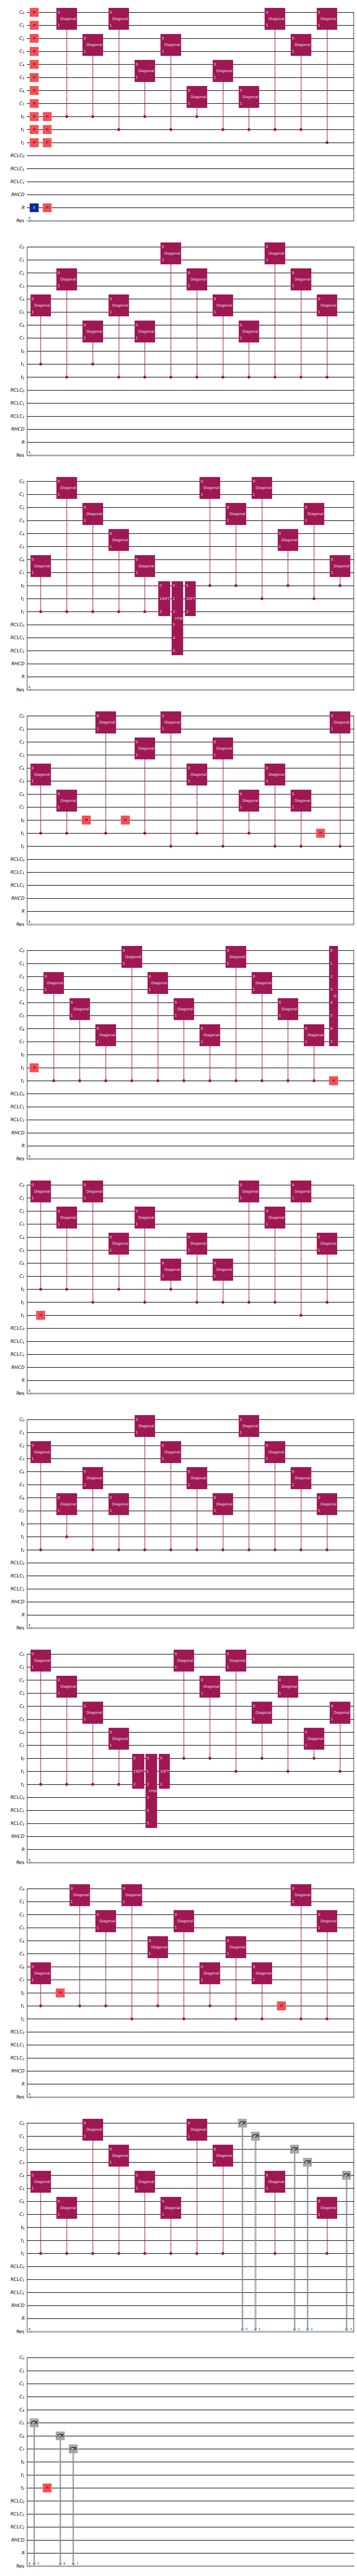

In [319]:
qr_C = QuantumRegister(m*N, 'C')
qr_t = QuantumRegister(t, 't')
qr_RCLC = QuantumRegister(t, 'RCLC')
qr_RHCD = QuantumRegister(1, 'RHCD')
qr_R = QuantumRegister(1, 'R')
cr_C = ClassicalRegister(m*N, 'Res')
registers = {"C":qr_C, "t":qr_t, "R":qr_R, "RCLC":qr_RCLC, "RHCD":qr_RHCD}

TSPcircuit = QuantumCircuit(qr_C, qr_t, qr_RCLC, qr_RHCD, qr_R, cr_C)

TSPcircuit.x(qr_R)
TSPcircuit.h(qr_R)

for qubit in range(m*N):
    TSPcircuit.h(qr_C[qubit])

for qubit in range(t):
    TSPcircuit.h(qr_t[qubit])

TSPcircuit = apply_clc(TSPcircuit, registers, constants, G)

TSPcircuit = apply_grover_diffusion_operator(TSPcircuit, registers, constants)

TSPcircuit = apply_clc(TSPcircuit, registers, constants, G)

TSPcircuit.measure(qr_C, cr_C)
TSPcircuit.draw(output='mpl')

In [320]:
sim = Aer.get_backend('qasm_simulator')
new_circuit = transpile(TSPcircuit, backend=sim)
job = sim.run(new_circuit) # Need to determine lower bound on suitable number of shots to take
result = job.result()
paths = result.get_counts()
print(paths)

{'01010001': 1, '10010100': 2, '10110001': 2, '11001101': 2, '11001100': 2, '00101010': 3, '10101111': 2, '01010110': 3, '11001110': 4, '11101100': 3, '00000000': 3, '00000011': 2, '01011011': 2, '10100110': 2, '11000110': 3, '00111010': 4, '10001011': 2, '10000100': 4, '10110000': 4, '11001111': 2, '00100001': 3, '01110110': 2, '00010011': 7, '01010101': 5, '01110011': 1, '00010010': 4, '11001000': 2, '00101001': 3, '11010000': 6, '01111110': 4, '11100111': 1, '01101111': 3, '10001110': 4, '11001011': 4, '11000101': 1, '11111101': 4, '00101011': 3, '11101010': 6, '01111001': 3, '10010010': 1, '00101111': 4, '10111001': 4, '11110011': 2, '11011001': 4, '10010001': 6, '10100001': 4, '10111101': 4, '11110110': 3, '11000111': 2, '00010101': 4, '11000100': 4, '11010110': 5, '01100110': 3, '00100110': 6, '11000011': 7, '10011101': 2, '00101101': 6, '10111011': 1, '10011011': 3, '10011001': 2, '01101011': 2, '10001001': 3, '11100110': 8, '11100100': 3, '01001100': 6, '00100111': 3, '01010011

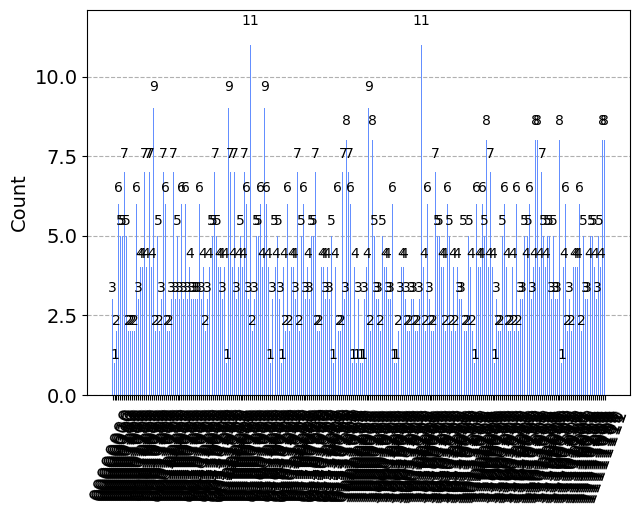

In [321]:
from qiskit.visualization import plot_histogram
plot_histogram(paths)

### Processing Measurements

In [322]:
def bitstring_to_decimal_path(N, m, bit_path):
    """ 
    Convert bitstring path to decimal path
    """
    int_path = []
    for i in range(N):
        city = bit_path[i * m : (i + 1) * m]
        int_path.append(int(city,2))
    return int_path

def check_hamiltonian_cycle(bitstring, num_cities, adj_mat, adj_list):
    d = np.max([len(l) for l in adj_list])
    m = int(np.ceil(np.log(d)))
    decimal_path = bitstring_to_decimal_path(num_cities, m, bitstring)
    cost = 0
    curr_city = 0
    count = 0
    path = [0]
    while (count < num_cities):
        if (curr_city >= len(adj_list) or decimal_path[curr_city] >= len(adj_list[curr_city])):
            return False, path, cost, True
        next_city = adj_list[curr_city][decimal_path[curr_city]]
        cost += adj_mat[curr_city, next_city]
        path.append(next_city)
        curr_city = next_city 
        count += 1
    if (len(set(path)) == num_cities and path[0] == path[-1]):
        return True, path, cost, False
    else:
        return False, path, cost, False

In [323]:
adj_matrix = nx.adjacency_matrix(G) # Adjacency Matrix for TSP Instance
adj_lists = [[c for c in G[i]] for i in G.nodes()] # Adjacency List for TSP Instance
d = np.max([len(l) for l in adj_lists])

In [324]:
bitstring_to_counts = {k: v for k, v in sorted(paths.items(), key=lambda item: item[1], reverse=True)}
# print("BITSTRING-TO-COUNTS DICT: " + str(bitstring_to_counts))
ham_cycles = []
skipped_cycles = []
non_ham_cycles = []
min_cost = len(G) * 2 * np.pi
min_cycle = 0
for path in bitstring_to_counts:
    bitstring = path
    is_ham_cycle, path, cost, skipped = check_hamiltonian_cycle(bitstring, len(G), adj_matrix, adj_lists)
    if (skipped):
        skipped_cycles.append((bitstring, bitstring_to_counts[bitstring]))
    if (is_ham_cycle):
        if (cost < min_cost):
            min_cost = cost 
            min_cycle = (bitstring, path)
        ham_cycles.append((bitstring, path, cost))
    else:
        non_ham_cycles.append((bitstring, path, cost, bitstring_to_counts[bitstring]))
print("PATHS THAT ARE NOT HAMILTONIAN CYCLES: " + str(non_ham_cycles))
print("HAMILTONIAN CYCLES: " + str(ham_cycles))
print('\n')
print("MINIMUM HAMILTONIAN CYCLE: " + str((min_cycle, min_cost, bitstring_to_counts[min_cycle[0]])))
print('\n')
print("SKIPPED CYCLES: " + str(skipped_cycles))

PATHS THAT ARE NOT HAMILTONIAN CYCLES: [('01000111', [0, 2, 1, 0, 2], 1.302, 11), ('10100000', [0, 3, 0, 3, 0], 0.86, 11), ('00010110', [0, 1, 2, 1, 2], 1.124, 9), ('10000101', [0, 3, 1, 0, 3], 0.591, 9), ('00111100', [0, 1], 0.038, 9), ('01001110', [0, 2], 0.451, 9), ('11100110', [0], 0, 8), ('11111111', [0], 0, 8), ('01111010', [0, 2, 3, 2, 3], 1.051, 8), ('10000111', [0, 3], 0.215, 8), ('11111110', [0], 0, 8), ('11011011', [0], 0, 8), ('11000001', [0], 0, 8), ('11011010', [0], 0, 8), ('00010011', [0, 1, 2, 0, 1], 0.889, 7), ('11000011', [0], 0, 7), ('00111101', [0, 1], 0.038, 7), ('00110101', [0, 1], 0.038, 7), ('01111000', [0, 2, 3, 0, 2], 1.317, 7), ('11011101', [0], 0, 7), ('00010001', [0, 1, 2, 0, 1], 0.889, 7), ('00010100', [0, 1, 2, 1, 2], 1.124, 7), ('01000100', [0, 2, 1, 0, 2], 1.302, 7), ('01011111', [0, 2], 0.451, 7), ('00011011', [0, 1, 2, 3], 0.6, 7), ('01111011', [0, 2, 3], 0.651, 7), ('00000111', [0, 1, 0, 1, 0], 0.152, 7), ('00100000', [0, 1, 3, 0, 1], 0.414, 7), ('01

In [325]:
# NetworkX Solution
nx_tsp = nx.approximation.traveling_salesman_problem
nx_tsp(G)

[0, 1, 3, 2, 3, 1, 0]

In [326]:
from qiskit_ibm_runtime.fake_provider import FakeAlgiers
sim = FakeAlgiers()
new_circuit = transpile(TSPcircuit, backend=sim)
job = sim.run(new_circuit) # Need to determine lower bound on suitable number of shots to take
result = job.result()
paths = result.get_counts()
print(paths)

{'01111010': 1, '01110011': 1, '00111111': 1, '01101001': 1, '00100110': 2, '11000101': 2, '11101101': 1, '01100010': 1, '11000100': 3, '11111011': 2, '11100111': 2, '11000010': 1, '11101100': 2, '10101001': 2, '11011010': 1, '10110001': 1, '00100111': 3, '10100010': 1, '00110110': 4, '10010100': 2, '11111101': 2, '01110101': 3, '11011001': 3, '11001101': 5, '10101100': 1, '10101111': 1, '11001110': 2, '01010110': 9, '10100000': 1, '00001111': 5, '10111111': 1, '11101000': 3, '10111011': 1, '10011011': 2, '01001011': 4, '11011101': 2, '01111001': 3, '10001011': 3, '10011101': 4, '00101101': 2, '10001110': 2, '11101110': 2, '01111000': 6, '01001101': 2, '01001001': 3, '10100110': 7, '00001110': 4, '10000000': 5, '01010011': 4, '10110101': 2, '10100100': 6, '11100011': 2, '10010011': 4, '01100110': 4, '01100001': 4, '00100001': 2, '11100010': 1, '11110101': 1, '01000111': 4, '11110000': 3, '10101110': 2, '11101011': 1, '01010001': 4, '00111000': 3, '11100100': 3, '01101111': 2, '11101001

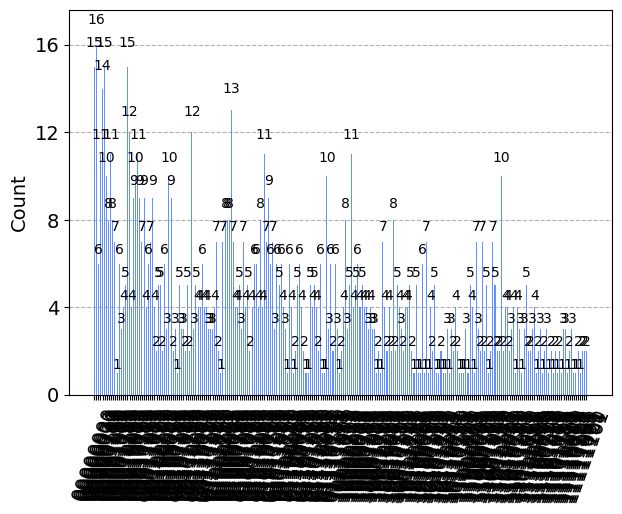

In [327]:
plot_histogram(paths)

In [328]:
bitstring_to_counts = {k: v for k, v in sorted(paths.items(), key=lambda item: item[1], reverse=True)}
# print("BITSTRING-TO-COUNTS DICT: " + str(bitstring_to_counts))
ham_cycles = []
skipped_cycles = []
non_ham_cycles = []
min_cost = len(G) * 2 * np.pi
min_cycle = 0
for path in bitstring_to_counts:
    bitstring = path
    is_ham_cycle, path, cost, skipped = check_hamiltonian_cycle(bitstring, len(G), adj_matrix, adj_lists)
    if (skipped):
        skipped_cycles.append((bitstring, bitstring_to_counts[bitstring]))
    if (is_ham_cycle):
        if (cost < min_cost):
            min_cost = cost 
            min_cycle = (bitstring, path)
        ham_cycles.append((bitstring, path, cost))
    else:
        non_ham_cycles.append((bitstring, path, cost, bitstring_to_counts[bitstring]))
print("PATHS THAT ARE NOT HAMILTONIAN CYCLES: " + str(non_ham_cycles))
print("HAMILTONIAN CYCLES: " + str(ham_cycles))
print('\n')
print("MINIMUM HAMILTONIAN CYCLE: " + str((min_cycle, min_cost, bitstring_to_counts[min_cycle[0]])))
print('\n')
print("SKIPPED CYCLES: " + str(skipped_cycles))

PATHS THAT ARE NOT HAMILTONIAN CYCLES: [('00000001', [0, 1, 0, 1, 0], 0.152, 16), ('00000000', [0, 1, 0, 1, 0], 0.152, 15), ('00000101', [0, 1, 0, 1, 0], 0.152, 15), ('00010000', [0, 1, 2, 0, 1], 0.889, 15), ('00000100', [0, 1, 0, 1, 0], 0.152, 14), ('01000100', [0, 2, 1, 0, 2], 1.302, 13), ('00110000', [0, 1], 0.038, 12), ('00010001', [0, 1, 2, 0, 1], 0.889, 12), ('00000011', [0, 1, 0, 1, 0], 0.152, 11), ('00010101', [0, 1, 2, 1, 2], 1.124, 11), ('10000001', [0, 3, 1, 0, 3], 0.591, 11), ('01010100', [0, 2, 1, 2, 1], 1.537, 11), ('00001000', [0, 1, 0, 1, 0], 0.152, 11), ('11010000', [0], 0, 10), ('00010100', [0, 1, 2, 1, 2], 1.124, 10), ('00000110', [0, 1, 0, 1, 0], 0.152, 10), ('00100100', [0, 1, 3, 0, 1], 0.414, 10), ('01110100', [0, 2, 1], 0.813, 10), ('01010110', [0, 2, 1, 2, 1], 1.537, 9), ('00100101', [0, 1, 3, 1, 3], 0.40700000000000003, 9), ('00011100', [0, 1, 2], 0.39999999999999997, 9), ('00010110', [0, 1, 2, 1, 2], 1.124, 9), ('00010011', [0, 1, 2, 0, 1], 0.889, 9), ('010000

In [ ]:
# Repeated circuit implementation
qr_C = QuantumRegister(m*N, 'C')
qr_t = QuantumRegister(t, 't')
qr_RCLC = QuantumRegister(t, 'RCLC')
qr_RHCD = QuantumRegister(1, 'RHCD')
qr_R = QuantumRegister(1, 'R')
cr_C = ClassicalRegister(m*N, 'Res')
registers = {"C":qr_C, "t":qr_t, "R":qr_R, "RCLC":qr_RCLC, "RHCD":qr_RHCD}

TSPcircuit = QuantumCircuit(qr_C, qr_t, qr_RCLC, qr_RHCD, qr_R, cr_C)

TSPcircuit.x(qr_R)
TSPcircuit.h(qr_R)

for qubit in range(m*N):
    TSPcircuit.h(qr_C[qubit])

for qubit in range(t):
    TSPcircuit.h(qr_t[qubit])

TSPcircuit = apply_clc(TSPcircuit, registers, constants, G)

TSPcircuit.ccx()

TSPcircuit = apply_grover_diffusion_operator(TSPcircuit, registers, constants)

TSPcircuit = apply_clc(TSPcircuit, registers, constants, G)

TSPcircuit.measure(qr_C, cr_C)
TSPcircuit.draw(output='mpl')